<a href="https://colab.research.google.com/github/jeongjun2000-hub/TimeSeriesForecastingTest/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비트코인 가격 변화 방향 예측 실습 노트북 📊

이 노트북에서는 비트코인 가격 데이터를 수집하고, 여러 머신러닝 모델을 사용하여 **다음 날 가격의 변화 방향(상승/하락)을 예측**합니다.

## 실습 목표
- 시계열 데이터 분석 및 특성 공학
- 고전 ML과 딥러닝 모델로 가격 방향 예측
- 예측 모델을 활용한 간단한 트레이딩 시뮬레이션

## 벤치마크 모델 구성
- **고전적 ML 모델**: 로지스틱 회귀, 랜덤 포레스트
- **딥러닝 베이스라인 모델**: LSTM, GRU

## 목차
1. 환경 설정 및 데이터 로딩
2. 데이터 탐색 및 시각화
3. 특성 공학 (Feature Engineering)
4. 데이터 전처리 및 분할
5. 벤치마크 모델 구현
   - Model 1: 로지스틱 회귀 (고전 ML)
   - Model 2: 랜덤 포레스트 (고전 ML)
   - Model 3: LSTM 신경망 (딥러닝)
   - Model 4: GRU 신경망 (딥러닝)
6. 모델 성능 비교
7. 트레이딩 시뮬레이션
8. 결과 분석 및 다음 단계

---

## 1. 환경 설정 및 데이터 로딩


In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [2]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 머신러닝 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 유틸리티 함수
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    compare_models,
    simulate_trading_strategy,
    calculate_trading_profit,
    calculate_buy_and_hold_return,
    compare_trading_strategies,
    plot_trading_results,
    print_trade_log,
    LSTMModel,
    GRUModel,
    train_pytorch_model,
    predict_pytorch_model,
    device
)

# 시각화 설정
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# 랜덤 시드 설정 (재현성)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [3]:
# 비트코인 데이터 다운로드
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
print(f"\n데이터 shape: {btc_data.shape}")
print(f"\n첫 5행:")
btc_data.head()

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-12-14


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2173 행

데이터 shape: (2173, 5)

첫 5행:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


## 2. 데이터 탐색 및 시각화

In [4]:
# 기본 통계 정보
print("=" * 70)
print("비트코인 데이터 기본 통계")
print("=" * 70)
btc_data.describe()

비트코인 데이터 기본 통계


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
count,2173.000000,2173.000000,2173.000000,2173.000000,2.173000e+03
mean,46840.745841,47726.767463,45829.507207,46804.384893,3.648092e+10
std,31326.713772,31803.906749,30802.638545,31324.645188,2.168046e+10
min,4970.788086,5331.833984,4106.980957,5002.578125,5.331173e+09
25%,21788.203125,22314.941406,21257.453125,21770.148438,2.221186e+10
50%,39469.292969,40483.785156,38235.535156,39472.207031,3.192726e+10
75%,63974.066406,65275.207031,62599.351562,63892.453125,4.535369e+10
max,124752.531250,126198.070312,123196.046875,124752.140625,3.509679e+11


In [5]:
# 결측치 확인
print("\n결측치 개수:")
print(btc_data.isnull().sum())


결측치 개수:
Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64


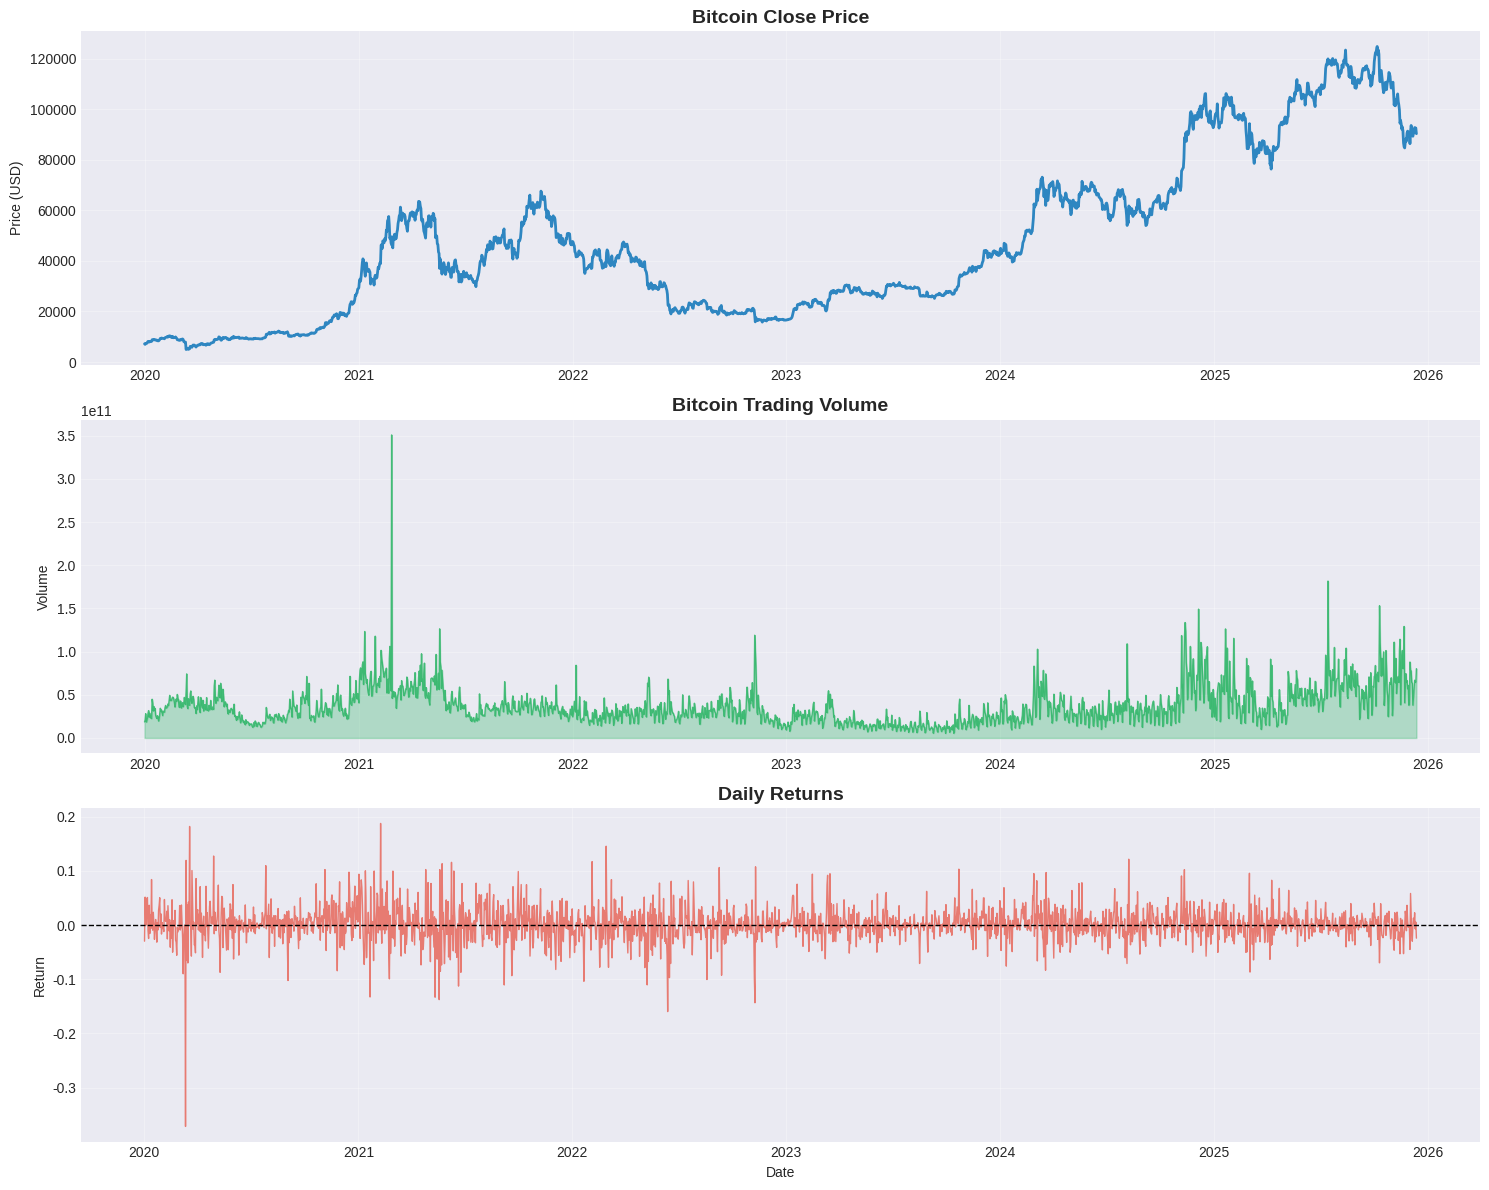

In [6]:
# 가격 추이 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 종가 추이
axes[0].plot(btc_data["Close"], linewidth=2, color="#2E86C1")
axes[0].set_title("Bitcoin Close Price", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Price (USD)")
axes[0].grid(True, alpha=0.3)

# 거래량 추이 - plot 사용
axes[1].plot(btc_data["Volume"], linewidth=1, color="#28B463", alpha=0.8)
axes[1].fill_between(btc_data.index, btc_data["Volume"].squeeze(), alpha=0.3, color="#28B463")
axes[1].set_title("Bitcoin Trading Volume", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Volume")
axes[1].grid(True, alpha=0.3)

# 일별 수익률
daily_returns = btc_data["Close"].pct_change()
axes[2].plot(daily_returns, linewidth=1, color="#E74C3C", alpha=0.7)
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[2].set_title("Daily Returns", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Return")
axes[2].set_xlabel("Date")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

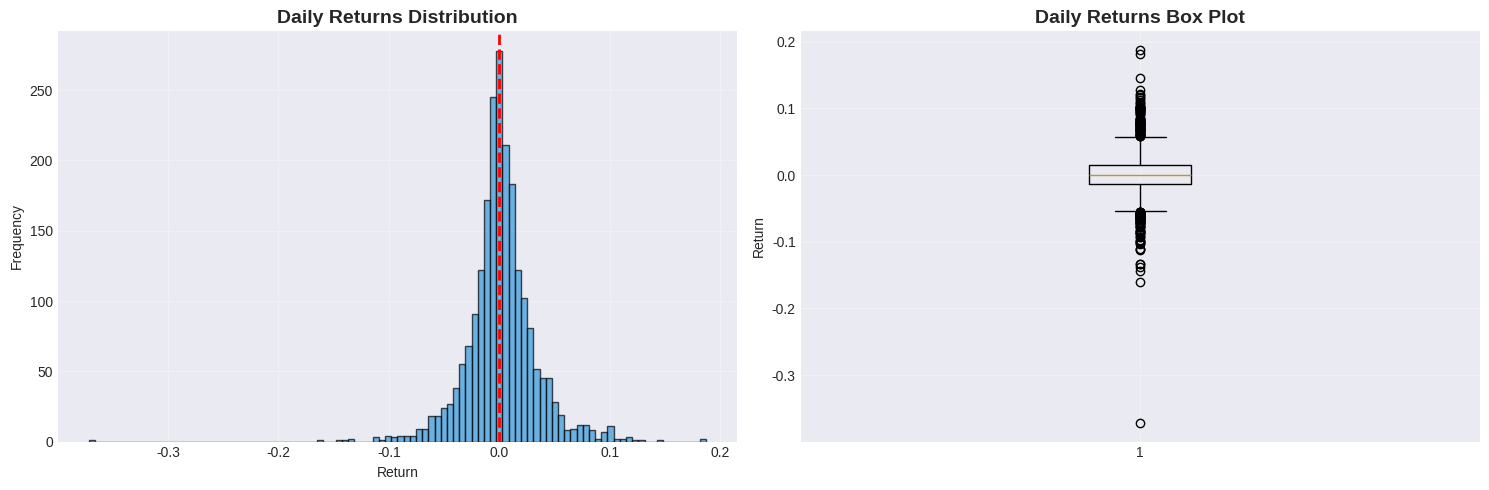


상승 일수: 1107 (50.97%)
하락 일수: 1065 (49.03%)


In [7]:
# 수익률 분포
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 히스토그램
axes[0].hist(daily_returns.dropna(), bins=100, color="#3498DB", alpha=0.7, edgecolor="black")
axes[0].set_title("Daily Returns Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Return")
axes[0].set_ylabel("Frequency")
axes[0].axvline(x=0, color="red", linestyle="--", linewidth=2)
axes[0].grid(True, alpha=0.3)

# 박스플롯
axes[1].boxplot(daily_returns.dropna(), vert=True)
axes[1].set_title("Daily Returns Box Plot", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 상승/하락 비율 - item()으로 스칼라 값 추출
up_days = int((daily_returns > 0).sum())
down_days = int((daily_returns < 0).sum())
total_days = len(daily_returns.dropna())

print(f"\n상승 일수: {up_days} ({up_days/total_days*100:.2f}%)")
print(f"하락 일수: {down_days} ({down_days/total_days*100:.2f}%)")

## 3. 특성 공학 (Feature Engineering)

기술적 지표를 활용하여 예측에 유용한 특성들을 생성합니다.

In [8]:
# 특성 생성
lookback_days = 10  # 과거 10일치 데이터 사용
btc_features = create_features(btc_data, lookback_days=lookback_days)

print(f"생성된 특성 수: {len(btc_features.columns)}")
print(f"\n특성 목록:")
print(btc_features.columns.tolist())

생성된 특성 수: 35

특성 목록:
['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'MA_5', 'MA_5_ratio', 'MA_10', 'MA_10_ratio', 'MA_20', 'MA_20_ratio', 'MA_50', 'MA_50_ratio', 'Volatility_5', 'Volatility_10', 'Volatility_20', 'Volume_Change', 'Volume_MA_5', 'Volume_ratio', 'High_Low_Range', 'RSI_14', 'MACD', 'MACD_Signal', 'Returns_Lag_1', 'Returns_Lag_2', 'Returns_Lag_3', 'Returns_Lag_4', 'Returns_Lag_5', 'Returns_Lag_6', 'Returns_Lag_7', 'Returns_Lag_8', 'Returns_Lag_9', 'Returns_Lag_10', 'Target']


In [9]:
# 생성된 특성 확인
btc_features.head(20)

Price,Close,High,Low,Open,Volume,Returns,MA_5,MA_5_ratio,MA_10,MA_10_ratio,...,Returns_Lag_2,Returns_Lag_3,Returns_Lag_4,Returns_Lag_5,Returns_Lag_6,Returns_Lag_7,Returns_Lag_8,Returns_Lag_9,Returns_Lag_10,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465,-0.029819,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032,0.051452,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275,0.008955,NaN,NaN,NaN,NaN,...,-0.029819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095,0.000089,7270.500586,1.019368,NaN,NaN,...,0.051452,-0.029819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-01-06,7769.219238,7781.867188,7409.292969,7410.452148,23276261598,0.048291,7384.309570,1.052125,NaN,NaN,...,0.008955,0.051452,-0.029819,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-01-07,8163.692383,8178.215820,7768.227539,7768.682129,28767291327,0.050774,7619.954004,1.071357,NaN,NaN,...,0.000089,0.008955,0.051452,-0.029819,NaN,NaN,NaN,NaN,NaN,0
2020-01-08,8079.862793,8396.738281,7956.774414,8161.935547,31672559265,-0.010269,7766.949707,1.040288,NaN,NaN,...,0.048291,0.000089,0.008955,0.051452,-0.029819,NaN,NaN,NaN,NaN,0
2020-01-09,7879.071289,8082.295898,7842.403809,8082.295898,24045990466,-0.024851,7860.632617,1.002346,NaN,NaN,...,0.050774,0.048291,0.000089,0.008955,0.051452,-0.029819,NaN,NaN,NaN,1



타겟 변수 분포:
하락(0): 1066 (49.06%)
상승(1): 1107 (50.94%)


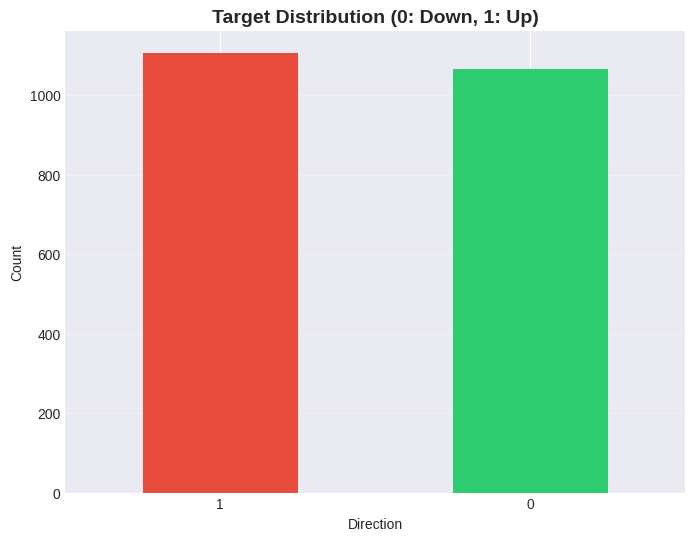

In [10]:
# 타겟 변수 분포 확인
target_counts = btc_features['Target'].value_counts()
print("\n타겟 변수 분포:")
print(f"하락(0): {target_counts[0]} ({target_counts[0]/len(btc_features)*100:.2f}%)")
print(f"상승(1): {target_counts[1]} ({target_counts[1]/len(btc_features)*100:.2f}%)")

# 시각화
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color=['#E74C3C', '#2ECC71'])
plt.title('Target Distribution (0: Down, 1: Up)', fontsize=14, fontweight='bold')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

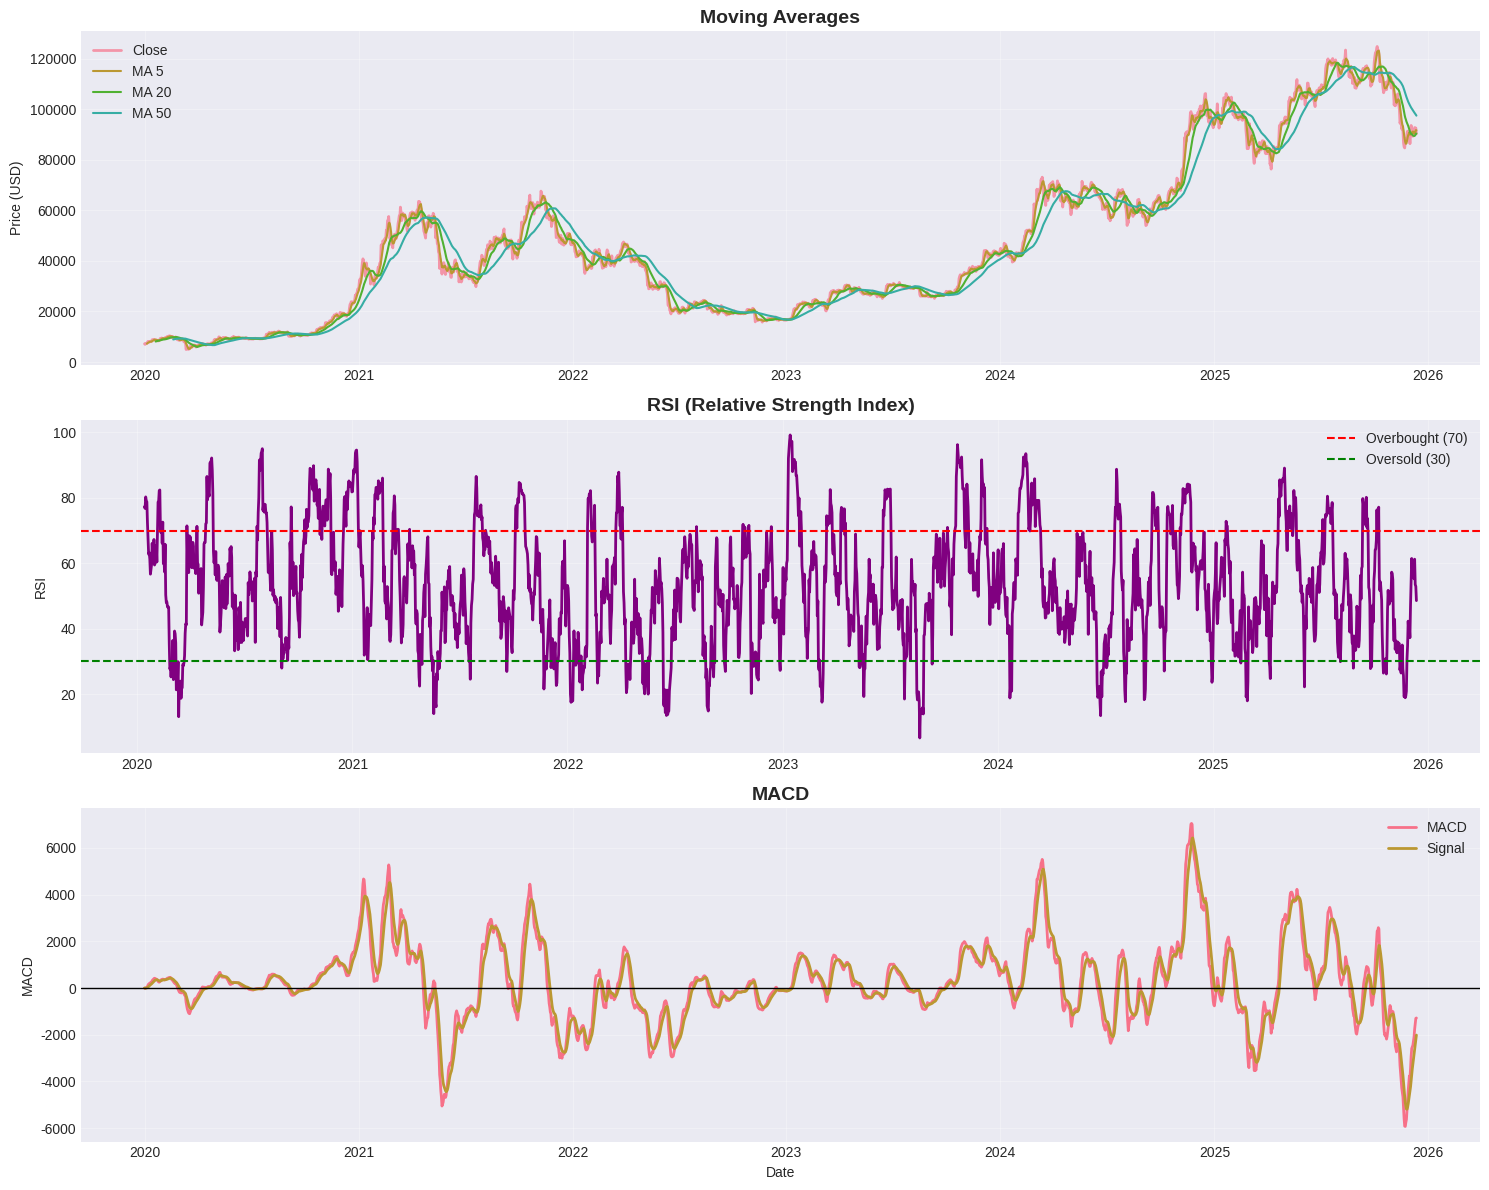

In [11]:
# 주요 기술적 지표 시각화
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 이동평균
axes[0].plot(btc_features.index, btc_features['Close'], label='Close', linewidth=2, alpha=0.7)
axes[0].plot(btc_features.index, btc_features['MA_5'], label='MA 5', linewidth=1.5)
axes[0].plot(btc_features.index, btc_features['MA_20'], label='MA 20', linewidth=1.5)
axes[0].plot(btc_features.index, btc_features['MA_50'], label='MA 50', linewidth=1.5)
axes[0].set_title('Moving Averages', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(btc_features.index, btc_features['RSI_14'], linewidth=2, color='purple')
axes[1].axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
axes[1].set_title('RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MACD
axes[2].plot(btc_features.index, btc_features['MACD'], label='MACD', linewidth=2)
axes[2].plot(btc_features.index, btc_features['MACD_Signal'], label='Signal', linewidth=2)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[2].set_title('MACD', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 데이터 전처리 및 분할

In [12]:
# 시퀀스 길이 정의 (딥러닝 모델에서 사용)
sequence_length = 30  # 과거 30일치 데이터를 한 시퀀스로 사용
print(f"시퀀스 길이: {sequence_length}일")

시퀀스 길이: 30일


In [13]:
# 학습/검증/테스트 데이터 분할
test_size = 0.2  # 테스트 데이터 비율
validation_size = 0.1  # 검증 데이터 비율

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features,
    test_size=test_size,
    validation_size=validation_size
)

print(f"원본 데이터 크기:")
print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")
print(f"\n특성 수: {X_train.shape[1]}")

학습 데이터: 1486 샘플
검증 데이터: 212 샘플
테스트 데이터: 426 샘플
원본 데이터 크기:
학습: 1486, 검증: 212, 테스트: 426

특성 수: 29


In [14]:
# 특성 정규화 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ 데이터 정규화 완료!")
print(f"\n학습 데이터 shape: {X_train_scaled.shape}")
print(f"검증 데이터 shape: {X_val_scaled.shape}")
print(f"테스트 데이터 shape: {X_test_scaled.shape}")

# 시퀀스 손실을 고려하여 고전 ML 모델도 동일한 테스트 기간 사용
# 딥러닝 모델의 시퀀스 생성 시 sequence_length만큼 데이터가 줄어들므로
# 고전 ML 모델도 마지막 sequence_length개 샘플만 테스트에 사용
X_test_scaled_aligned = X_test_scaled[sequence_length:]
y_test_aligned = y_test.iloc[sequence_length:].values

print(f"\n⚠️ 공정한 비교를 위해 테스트 데이터 정렬:")
print(f"고전 ML 테스트: {len(X_test_scaled)} → {len(X_test_scaled_aligned)} (시퀀스 길이 {sequence_length} 제외)")
print(f"딥러닝 테스트: 시퀀스 생성 후 {len(X_test_scaled_aligned)}개 샘플 (동일)")

✅ 데이터 정규화 완료!

학습 데이터 shape: (1486, 29)
검증 데이터 shape: (212, 29)
테스트 데이터 shape: (426, 29)

⚠️ 공정한 비교를 위해 테스트 데이터 정렬:
고전 ML 테스트: 426 → 396 (시퀀스 길이 30 제외)
딥러닝 테스트: 시퀀스 생성 후 396개 샘플 (동일)


## 5. 벤치마크 모델 구현

### 5.1 Model 1: 로지스틱 회귀 (고전 ML 베이스라인)

### 5.1 Model 1: 로지스틱 회귀 (고전 ML 베이스라인)

로지스틱 회귀는 이진 분류를 위한 가장 기본적인 머신러닝 알고리즘입니다.
비트코인 가격이 상승할지(1) 하락할지(0)를 예측합니다.

In [15]:
# 로지스틱 회귀 모델 학습
print("=" * 70)
print("1. 로지스틱 회귀 (Logistic Regression) 모델 학습")
print("=" * 70)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

print("✅ 로지스틱 회귀 모델 학습 완료!")

1. 로지스틱 회귀 (Logistic Regression) 모델 학습
✅ 로지스틱 회귀 모델 학습 완료!



[학습 데이터 성능]

Logistic Regression - Train 성능 평가
정확도 (Accuracy):  0.5612
정밀도 (Precision): 0.5659
재현율 (Recall):    0.6150
F1 Score:          0.5894


[검증 데이터 성능]

Logistic Regression - Validation 성능 평가
정확도 (Accuracy):  0.5236
정밀도 (Precision): 0.5254
재현율 (Recall):    0.2981
F1 Score:          0.3804


[테스트 데이터 성능 - 정렬된 데이터]

Logistic Regression - Test 성능 평가
정확도 (Accuracy):  0.5253
정밀도 (Precision): 0.7273
재현율 (Recall):    0.0808
F1 Score:          0.1455



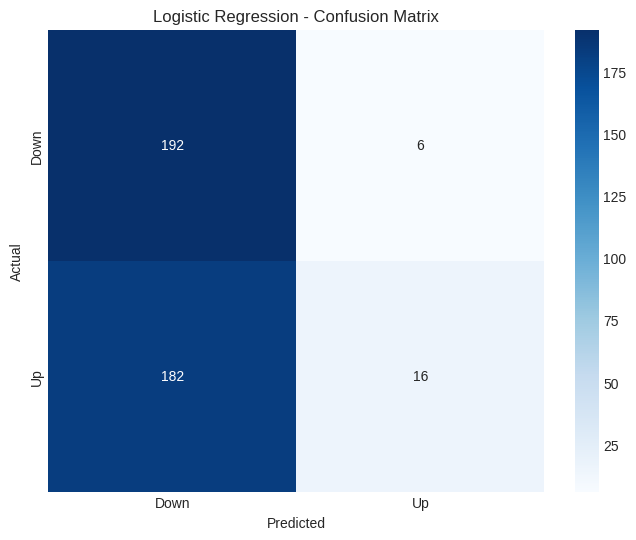

In [16]:
# 로지스틱 회귀 성능 평가
print("\n[학습 데이터 성능]")
y_pred_lr_train = lr_model.predict(X_train_scaled)
lr_results_train = evaluate_model(y_train, y_pred_lr_train, "Logistic Regression - Train")

print("\n[검증 데이터 성능]")
y_pred_lr_val = lr_model.predict(X_val_scaled)
lr_results_val = evaluate_model(y_val, y_pred_lr_val, "Logistic Regression - Validation")

print("\n[테스트 데이터 성능 - 정렬된 데이터]")
y_pred_lr_test = lr_model.predict(X_test_scaled_aligned)
lr_results_test = evaluate_model(y_test_aligned, y_pred_lr_test, "Logistic Regression - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_aligned, y_pred_lr_test, "Logistic Regression")

### 5.2 Model 2: 랜덤 포레스트 (고전 ML 베이스라인)

In [17]:
# 랜덤 포레스트 모델 학습
print("=" * 70)
print("2. 랜덤 포레스트 (Random Forest) 모델 학습")
print("=" * 70)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

print("✅ 랜덤 포레스트 모델 학습 완료!")

2. 랜덤 포레스트 (Random Forest) 모델 학습
✅ 랜덤 포레스트 모델 학습 완료!



[학습 데이터 성능]

Random Forest - Train 성능 평가
정확도 (Accuracy):  0.9906
정밀도 (Precision): 0.9973
재현율 (Recall):    0.9842
F1 Score:          0.9907


[검증 데이터 성능]

Random Forest - Validation 성능 평가
정확도 (Accuracy):  0.5000
정밀도 (Precision): 0.4875
재현율 (Recall):    0.3750
F1 Score:          0.4239


[테스트 데이터 성능 - 정렬된 데이터]

Random Forest - Test 성능 평가
정확도 (Accuracy):  0.4697
정밀도 (Precision): 0.4455
재현율 (Recall):    0.2475
F1 Score:          0.3182



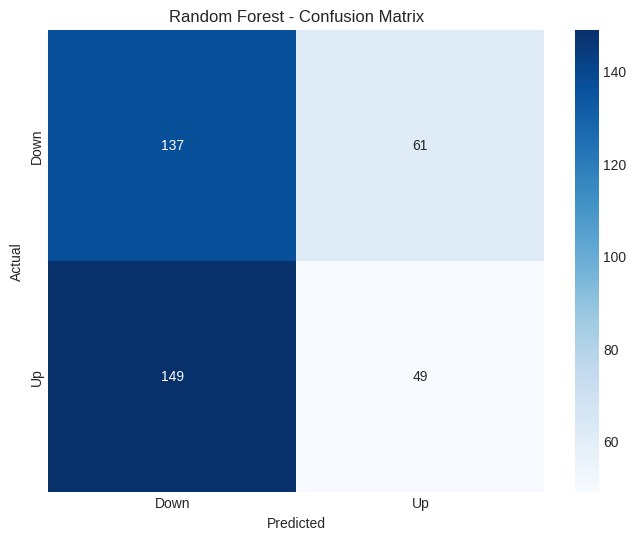

In [18]:
# 랜덤 포레스트 성능 평가
print("\n[학습 데이터 성능]")
y_pred_rf_train = rf_model.predict(X_train_scaled)
rf_results_train = evaluate_model(y_train, y_pred_rf_train, "Random Forest - Train")

print("\n[검증 데이터 성능]")
y_pred_rf_val = rf_model.predict(X_val_scaled)
rf_results_val = evaluate_model(y_val, y_pred_rf_val, "Random Forest - Validation")

print("\n[테스트 데이터 성능 - 정렬된 데이터]")
y_pred_rf_test = rf_model.predict(X_test_scaled_aligned)
rf_results_test = evaluate_model(y_test_aligned, y_pred_rf_test, "Random Forest - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_aligned, y_pred_rf_test, "Random Forest")


상위 20개 중요 특성:
           feature  importance
0          Returns    0.046296
26   Returns_Lag_8    0.043260
2       MA_5_ratio    0.041915
8      MA_50_ratio    0.040567
16          RSI_14    0.039285
10   Volatility_10    0.038983
22   Returns_Lag_4    0.038599
20   Returns_Lag_2    0.038168
6      MA_20_ratio    0.037529
28  Returns_Lag_10    0.037512
23   Returns_Lag_5    0.037252
25   Returns_Lag_7    0.037200
24   Returns_Lag_6    0.036486
15  High_Low_Range    0.036131
27   Returns_Lag_9    0.035724
21   Returns_Lag_3    0.033362
9     Volatility_5    0.033154
19   Returns_Lag_1    0.032840
14    Volume_ratio    0.032667
13     Volume_MA_5    0.032450


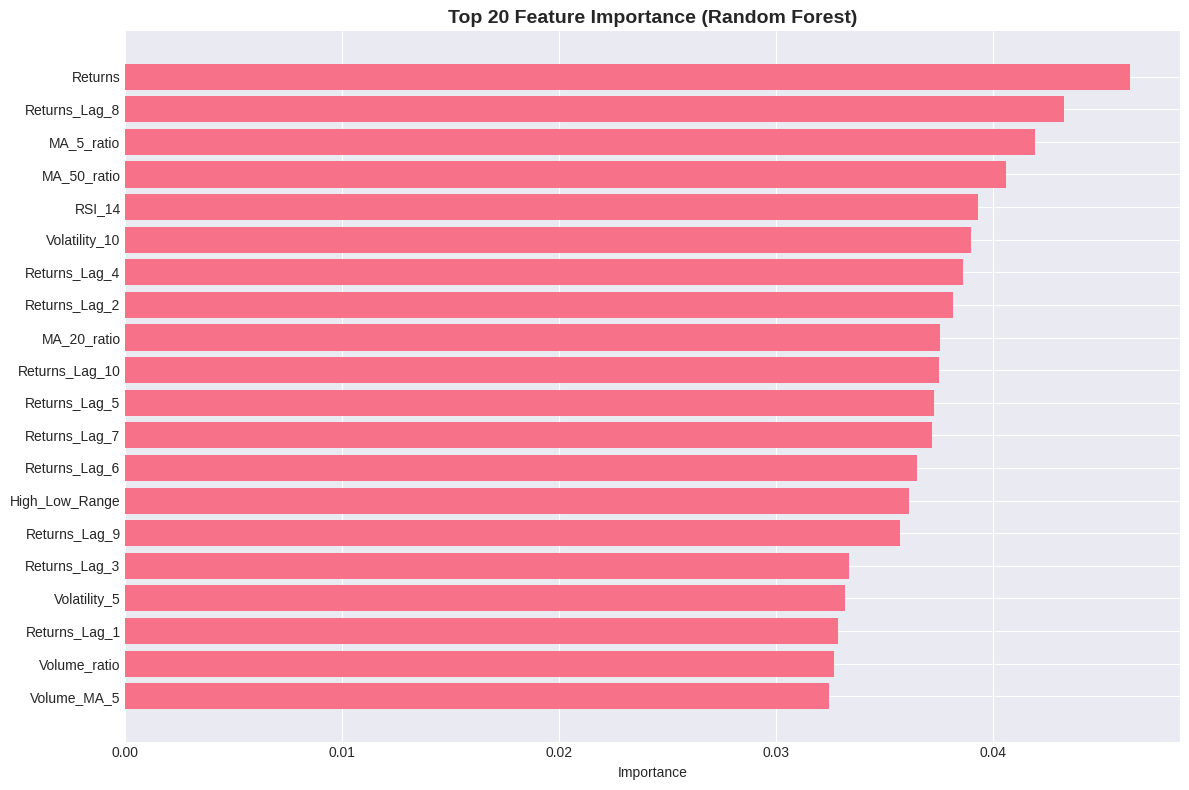

In [19]:
# 특성 중요도 분석
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n상위 20개 중요 특성:")
print(feature_importance.head(20))

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 5.3 딥러닝 모델을 위한 데이터 준비

딥러닝 모델(LSTM, GRU)을 위해 시퀀스 데이터로 변환합니다.

In [20]:
def create_sequences(X, y, sequence_length=30):
    """
    시퀀스 데이터 생성 (딥러닝용)

    Parameters:
    -----------
    X : array-like
        특성 데이터
    y : array-like
        타겟 데이터
    sequence_length : int
        시퀀스 길이

    Returns:
    --------
    tuple
        (X_seq, y_seq)
    """
    X_seq = []
    y_seq = []

    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])

    return np.array(X_seq), np.array(y_seq)

# 시퀀스 생성
sequence_length = 30  # 과거 30일치 데이터를 한 시퀀스로 사용

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print("✅ 시퀀스 데이터 생성 완료!")
print(f"\n학습 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")
print(f"\n검증 데이터 shape: {X_val_seq.shape}")
print(f"테스트 데이터 shape: {X_test_seq.shape}")

# PyTorch DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True) # drop_last=True 추가

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # 검증 데이터는 drop_last=False 유지 가능

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # 테스트 데이터는 drop_last=False 유지 가능

print("\n✅ PyTorch DataLoader 생성 완료!")

✅ 시퀀스 데이터 생성 완료!

학습 데이터 shape: (1456, 30, 29)
  - 샘플 수: 1456
  - 시퀀스 길이: 30
  - 특성 수: 29

검증 데이터 shape: (182, 30, 29)
테스트 데이터 shape: (396, 30, 29)

✅ PyTorch DataLoader 생성 완료!


### 5.4 Model 3: LSTM 신경망 (딥러닝 베이스라인)

In [21]:
# LSTM 모델 구축 (PyTorch)
print("\n" + "="*70)
print("LSTM 모델 구축 시작")
print("="*70)

input_size = X_train_seq.shape[2]
lstm_model = LSTMModel(input_size=input_size, hidden_size=64, dropout=0.2)

# 모델 구조 출력
print("\n모델 구조:")
print(lstm_model)
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad):,}")
print(f"\nDevice: {device}")


LSTM 모델 구축 시작

모델 구조:
LSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601
Trainable parameters: 37,601

Device: cuda


In [22]:
# LSTM 모델 학습
print("\nLSTM 모델 학습 시작...")

history_lstm = train_pytorch_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)

print("\n✅ LSTM 모델 학습 완료!")


LSTM 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6780, Val Loss: 0.7064, Train Acc: 0.5729, Val Acc: 0.4945
Early stopping at epoch 19

✅ LSTM 모델 학습 완료!


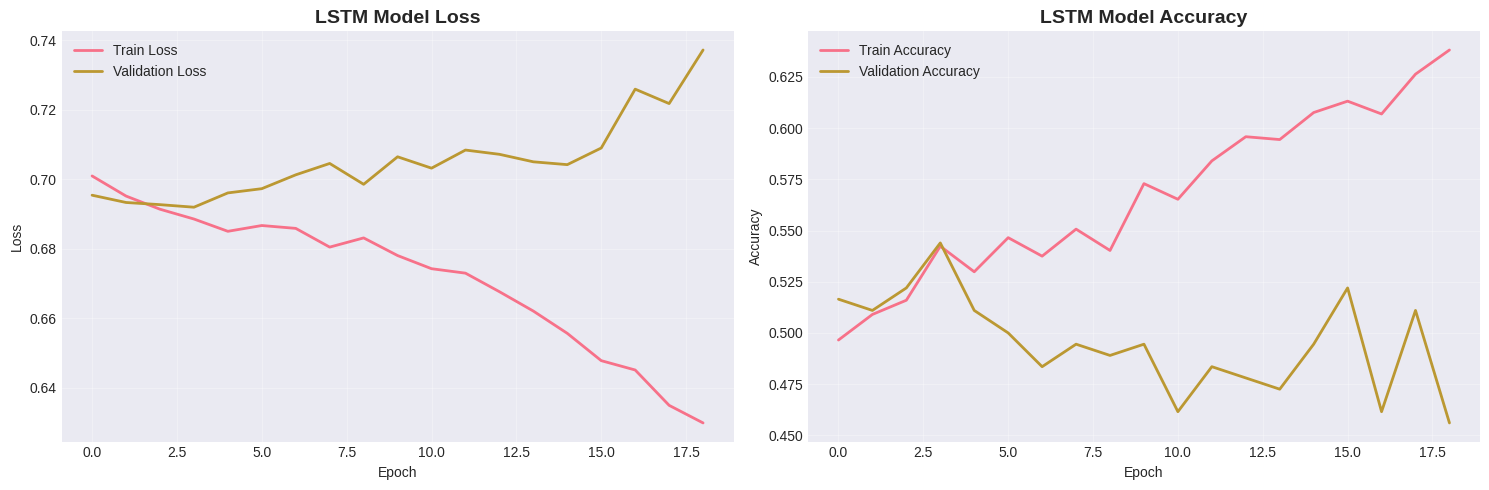

In [23]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_lstm["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(history_lstm["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("LSTM Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_lstm["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(history_lstm["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("LSTM Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[학습 데이터 성능]

LSTM - Train 성능 평가
정확도 (Accuracy):  0.5000
정밀도 (Precision): 0.5119
재현율 (Recall):    0.5535
F1 Score:          0.5319


[검증 데이터 성능]

LSTM - Validation 성능 평가
정확도 (Accuracy):  0.4560
정밀도 (Precision): 0.4583
재현율 (Recall):    0.6180
F1 Score:          0.5263


[테스트 데이터 성능]

LSTM - Test 성능 평가
정확도 (Accuracy):  0.4874
정밀도 (Precision): 0.4845
재현율 (Recall):    0.3939
F1 Score:          0.4345



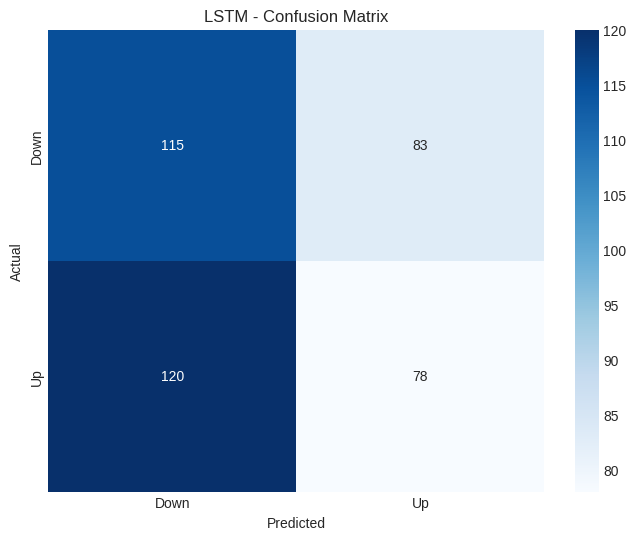

In [25]:
# LSTM 예측 및 성능 평가
y_pred_lstm_train_prob, y_pred_lstm_train = predict_pytorch_model(lstm_model, train_loader)
y_pred_lstm_val_prob, y_pred_lstm_val = predict_pytorch_model(lstm_model, val_loader)
y_pred_lstm_test_prob, y_pred_lstm_test = predict_pytorch_model(lstm_model, test_loader)

# Adjust y_train_seq to match the length of predictions from train_loader (due to drop_last=True)
# The length of y_pred_lstm_train is (len(y_train_seq) // batch_size) * batch_size
adjusted_y_train_seq = y_train_seq[:len(y_pred_lstm_train)]

print("\n[학습 데이터 성능]")
lstm_results_train = evaluate_model(adjusted_y_train_seq, y_pred_lstm_train, "LSTM - Train")

print("\n[검증 데이터 성능]")
lstm_results_val = evaluate_model(y_val_seq, y_pred_lstm_val, "LSTM - Validation")

print("\n[테스트 데이터 성능]")
lstm_results_test = evaluate_model(y_test_seq, y_pred_lstm_test, "LSTM - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_seq, y_pred_lstm_test, "LSTM")

### 5.5 Model 4: GRU 신경망 (딥러닝 베이스라인)

In [26]:
# GRU 모델 구축 (PyTorch)
print("\n" + "="*70)
print("GRU 모델 구축 시작")
print("="*70)

input_size = X_train_seq.shape[2]
gru_model = GRUModel(input_size=input_size, hidden_size=64, dropout=0.2)

# 모델 구조 출력
print("\n모델 구조:")
print(gru_model)
print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in gru_model.parameters() if p.requires_grad):,}")
print(f"\nDevice: {device}")


GRU 모델 구축 시작

모델 구조:
GRUModel(
  (gru1): GRU(29, 64, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru2): GRU(64, 32, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 28,385
Trainable parameters: 28,385

Device: cuda


In [27]:
# GRU 모델 학습
print("\nGRU 모델 학습 시작...")

history_gru = train_pytorch_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=0.001,
    patience=15
)

print("\n✅ GRU 모델 학습 완료!")


GRU 모델 학습 시작...
Epoch [10/100], Train Loss: 0.6841, Val Loss: 0.6956, Train Acc: 0.5556, Val Acc: 0.4615
Early stopping at epoch 18

✅ GRU 모델 학습 완료!


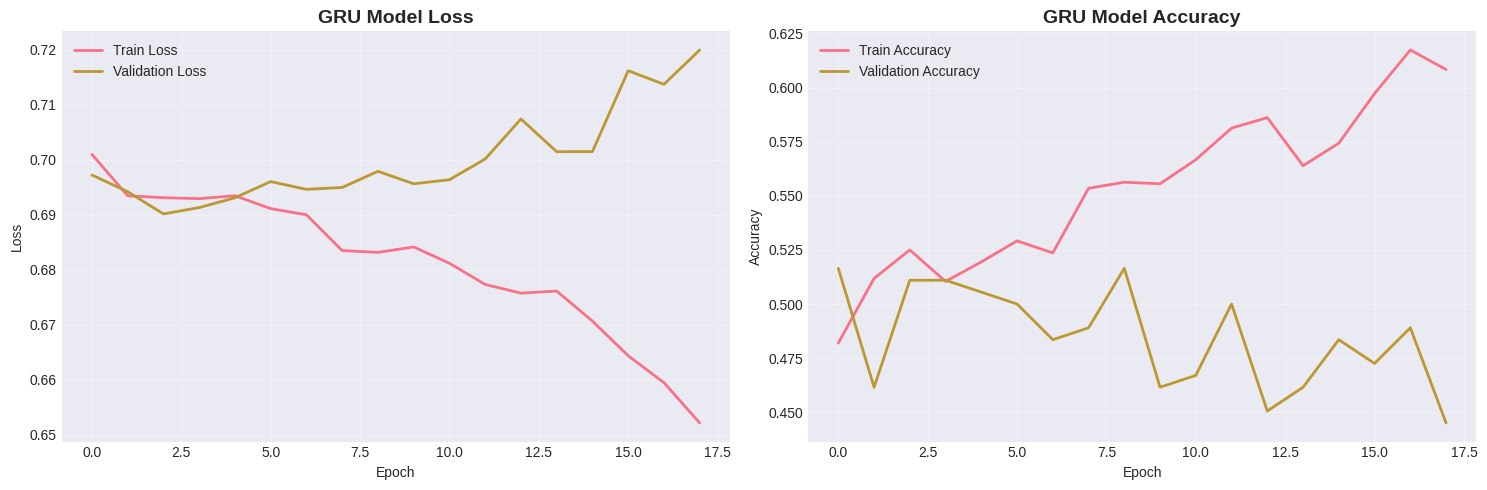

In [28]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_gru["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(history_gru["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("GRU Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_gru["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(history_gru["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("GRU Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# GRU 예측 및 성능 평가
y_pred_gru_train_prob, y_pred_gru_train = predict_pytorch_model(gru_model, train_loader)
y_pred_gru_val_prob, y_pred_gru_val = predict_pytorch_model(gru_model, val_loader)
y_pred_gru_test_prob, y_pred_gru_test = predict_pytorch_model(gru_model, test_loader)

print("\n[학습 데이터 성능]")
gru_results_train = evaluate_model(y_train_seq, y_pred_gru_train, "GRU - Train")

print("\n[검증 데이터 성능]")
gru_results_val = evaluate_model(y_val_seq, y_pred_gru_val, "GRU - Validation")

print("\n[테스트 데이터 성능]")
gru_results_test = evaluate_model(y_test_seq, y_pred_gru_test, "GRU - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_seq, y_pred_gru_test, "GRU")


[학습 데이터 성능]


ValueError: Found input variables with inconsistent numbers of samples: [1456, 1440]


[학습 데이터 성능]

GRU - Train 성능 평가
정확도 (Accuracy):  0.5035
정밀도 (Precision): 0.5152
재현율 (Recall):    0.5507
F1 Score:          0.5324


[검증 데이터 성능]

GRU - Validation 성능 평가
정확도 (Accuracy):  0.4451
정밀도 (Precision): 0.4250
재현율 (Recall):    0.3820
F1 Score:          0.4024


[테스트 데이터 성능]

GRU - Test 성능 평가
정확도 (Accuracy):  0.5202
정밀도 (Precision): 0.5253
재현율 (Recall):    0.4192
F1 Score:          0.4663



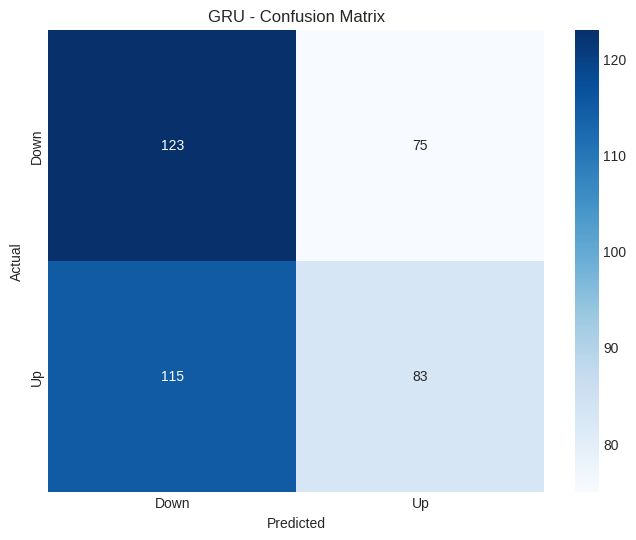

In [31]:
# GRU 예측 및 성능 평가
y_pred_gru_train_prob, y_pred_gru_train = predict_pytorch_model(gru_model, train_loader)
y_pred_gru_val_prob, y_pred_gru_val = predict_pytorch_model(gru_model, val_loader)
y_pred_gru_test_prob, y_pred_gru_test = predict_pytorch_model(gru_model, test_loader)

# Adjust y_train_seq to match the length of predictions from train_loader (due to drop_last=True)
adjusted_y_train_seq_gru = y_train_seq[:len(y_pred_gru_train)]

print("\n[학습 데이터 성능]")
gru_results_train = evaluate_model(adjusted_y_train_seq_gru, y_pred_gru_train, "GRU - Train")

print("\n[검증 데이터 성능]")
gru_results_val = evaluate_model(y_val_seq, y_pred_gru_val, "GRU - Validation")

print("\n[테스트 데이터 성능]")
gru_results_test = evaluate_model(y_test_seq, y_pred_gru_test, "GRU - Test")

# 혼동 행렬
plot_confusion_matrix(y_test_seq, y_pred_gru_test, "GRU")

## 6. 모델 성능 비교

4개의 벤치마크 모델 성능을 종합적으로 비교합니다.

In [32]:
# Buy and Hold 베이스라인 계산
# 테스트 기간의 첫날 가격과 마지막날 가격으로 수익률 계산
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_end_idx = len(btc_features)

test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_end_idx].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_end_idx]

buy_and_hold_return = (test_prices_aligned[-1] - test_prices_aligned[0]) / test_prices_aligned[0] * 100

print("\n" + "="*70)
print("📊 Buy and Hold 베이스라인 (테스트 기간)")
print("="*70)
print(f"시작일: {test_dates_aligned[0]}")
print(f"종료일: {test_dates_aligned[-1]}")
print(f"시작 가격: ${test_prices_aligned[0]:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"수익률: {buy_and_hold_return:.2f}%")
print("="*70)

# Buy and Hold 결과를 딕셔너리로 저장
buy_and_hold_results = {
    "accuracy": 0.5,  # 단순 매수 보유는 예측이 아니므로 의미 없음
    "precision": 0.5,
    "recall": 0.5,
    "f1": 0.5,
    "return": buy_and_hold_return
}


📊 Buy and Hold 베이스라인 (테스트 기간)
시작일: 2024-11-12 00:00:00
종료일: 2025-12-12 00:00:00
시작 가격: $87,955.81
종료 가격: $90,270.41
수익률: 2.63%



모델 성능 비교
                         accuracy  precision    recall        f1   return
Buy and Hold (Baseline)  0.500000   0.500000  0.500000  0.500000  2.63155
Logistic Regression      0.525253   0.727273  0.080808  0.145455      NaN
Random Forest            0.469697   0.445455  0.247475  0.318182      NaN
LSTM                     0.487374   0.484472  0.393939  0.434540      NaN
GRU                      0.520202   0.525316  0.419192  0.466292      NaN



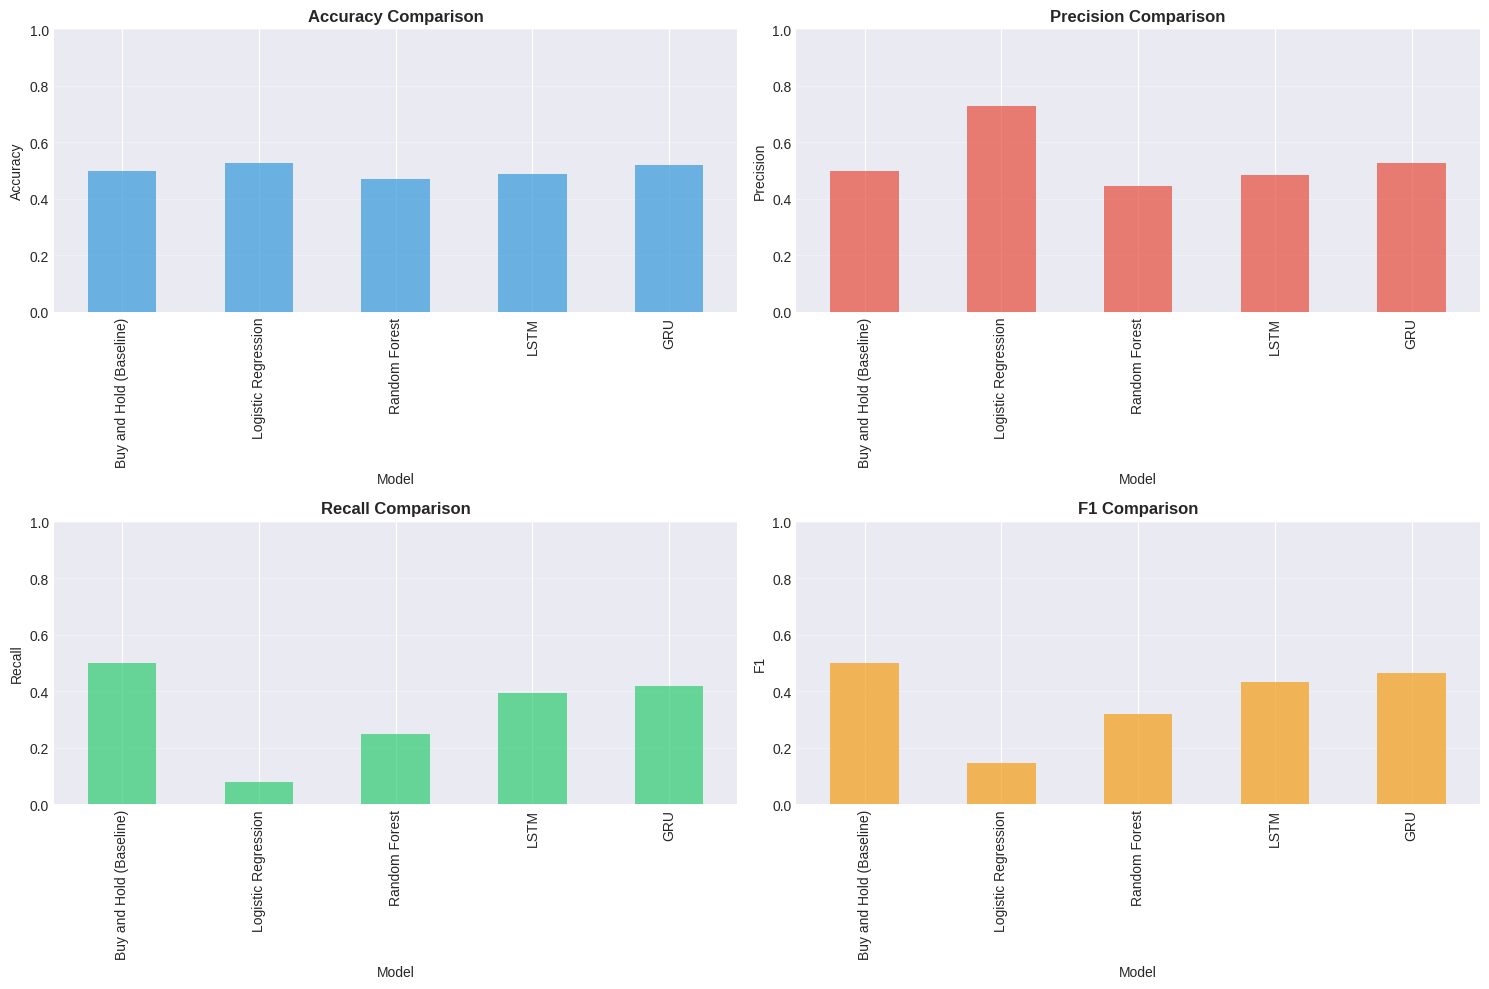


💡 참고:
- Buy and Hold는 예측 모델이 아니므로 정확도 지표는 의미가 없습니다.
- 테스트 기간 수익률: 2.63%
- 예측 모델들은 이 수익률을 초과하는 것이 목표입니다.


In [33]:
# 테스트 데이터 성능 비교 (Buy and Hold 베이스라인 포함)
results_comparison = {
    "Buy and Hold (Baseline)": buy_and_hold_results,
    "Logistic Regression": lr_results_test,
    "Random Forest": rf_results_test,
    "LSTM": lstm_results_test,
    "GRU": gru_results_test
}

compare_models(results_comparison)

print("\n💡 참고:")
print("- Buy and Hold는 예측 모델이 아니므로 정확도 지표는 의미가 없습니다.")
print(f"- 테스트 기간 수익률: {buy_and_hold_return:.2f}%")
print("- 예측 모델들은 이 수익률을 초과하는 것이 목표입니다.")


검증 vs 테스트 정확도 비교:
                 Model  Val Accuracy  Test Accuracy
0  Logistic Regression      0.523585       0.525253
1        Random Forest      0.500000       0.469697
2                 LSTM      0.456044       0.487374
3                  GRU      0.445055       0.520202


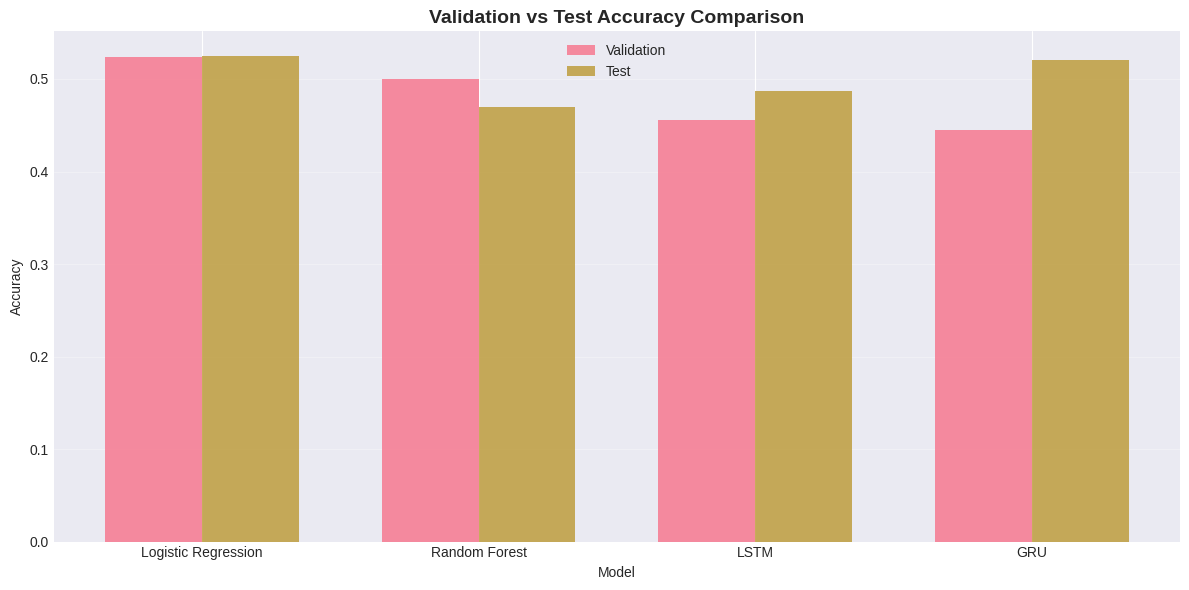

In [34]:
# 검증 vs 테스트 성능 비교
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM', 'GRU'],
    'Val Accuracy': [
        lr_results_val['accuracy'],
        rf_results_val['accuracy'],
        lstm_results_val['accuracy'],
        gru_results_val['accuracy']
    ],
    'Test Accuracy': [
        lr_results_test['accuracy'],
        rf_results_test['accuracy'],
        lstm_results_test['accuracy'],
        gru_results_test['accuracy']
    ]
})

print("\n검증 vs 테스트 정확도 비교:")
print(comparison_df)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Val Accuracy'], width, label='Validation', alpha=0.8)
ax.bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Validation vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. 결과 분석 및 인사이트

In [35]:
# 거래 전략 시뮬레이션
print("\n" + "="*70)
print("거래 전략 시뮬레이션 (초기 자본 $10,000)")
print("="*70)

trading_results = {}

print("\n[1] Logistic Regression 전략")
trading_results['LR'] = calculate_trading_profit(y_test, y_pred_lr_test, initial_capital=10000)

print("\n[2] Random Forest 전략")
trading_results['RF'] = calculate_trading_profit(y_test, y_pred_rf_test, initial_capital=10000)

print("\n[3] LSTM 전략")
trading_results['LSTM'] = calculate_trading_profit(y_test_seq, y_pred_lstm_test, initial_capital=10000)

print("\n[4] GRU 전략")
trading_results['GRU'] = calculate_trading_profit(y_test_seq, y_pred_gru_test, initial_capital=10000)


거래 전략 시뮬레이션 (초기 자본 $10,000)

[1] Logistic Regression 전략

거래 전략 수익률
초기 자본: $10,000.00
최종 자본: $9,989.01
수익률: -0.11%


[2] Random Forest 전략

거래 전략 수익률
초기 자본: $10,000.00
최종 자본: $9,365.97
수익률: -6.34%


[3] LSTM 전략

거래 전략 수익률
초기 자본: $10,000.00
최종 자본: $9,436.01
수익률: -5.64%


[4] GRU 전략

거래 전략 수익률
초기 자본: $10,000.00
최종 자본: $10,747.65
수익률: 7.48%



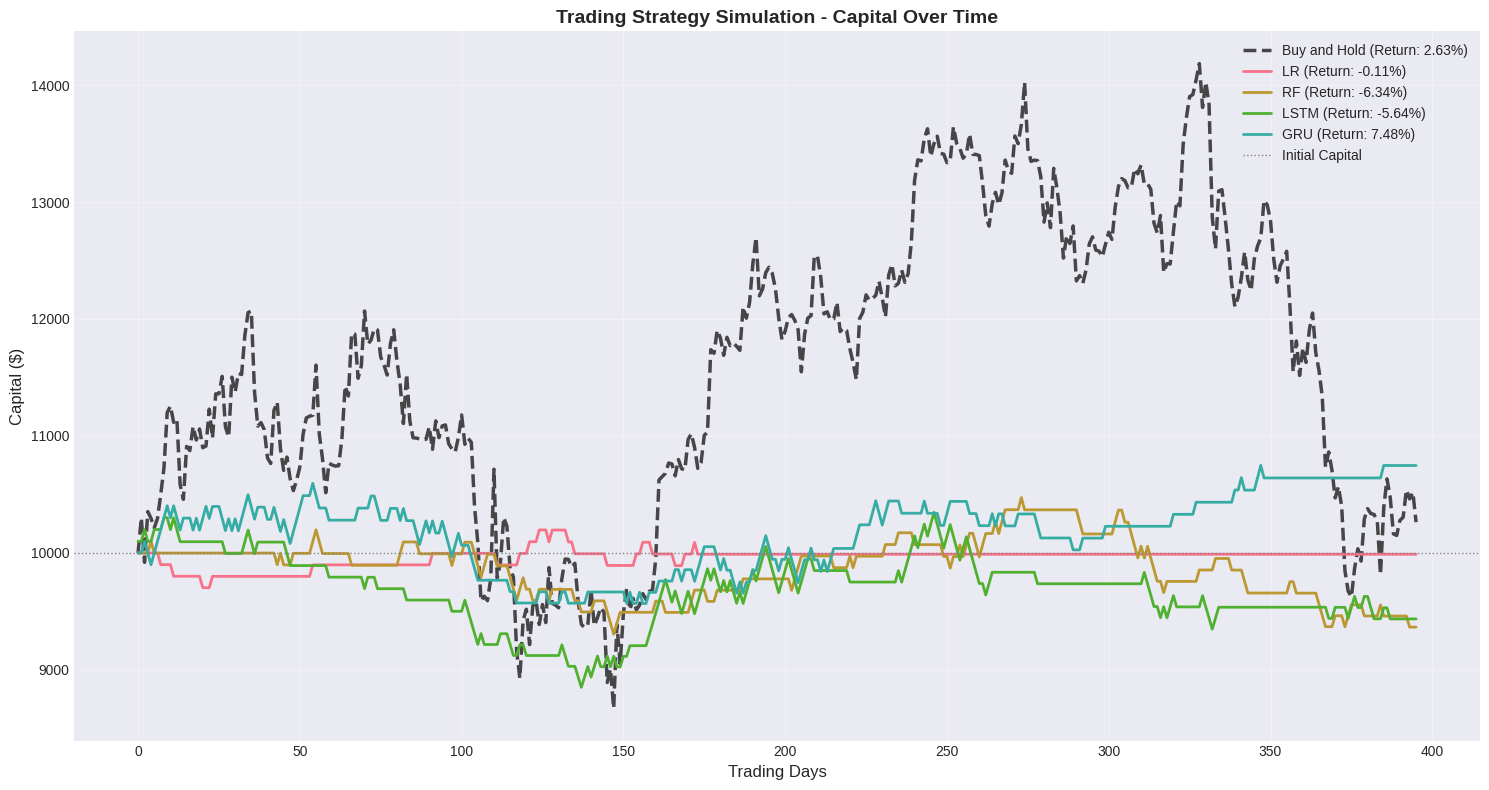


💡 Buy and Hold 상세 정보:
   - 초기 가격: $87,955.81
   - 구매한 코인 수: 0.113693 BTC
   - 최종 가격: $90,270.41
   - 최종 자산 가치: $10,263.16
   - 수익률: 2.63%

💡 해석:
   - Buy and Hold (검은 점선)이 베이스라인입니다.
   - 이 선보다 위에 있으면 해당 전략이 더 수익이 높습니다.
   - 이 선보다 아래에 있으면 그냥 사서 보유하는 것이 더 나았습니다.


In [36]:
# 자본 변화 시각화 (Buy and Hold 포함)
plt.figure(figsize=(15, 8))

# Buy and Hold 베이스라인: 시작일에 전액으로 코인 매수 후 가격 변동 반영
initial_price = test_prices_aligned[0]
coins_bought = 10000 / initial_price  # 초기 자본으로 살 수 있는 코인 수
buy_hold_values = [coins_bought * price for price in test_prices_aligned]  # 매일 자산 가치

plt.plot(buy_hold_values, label=f"Buy and Hold (Return: {buy_and_hold_return:.2f}%)",
         linewidth=2.5, linestyle="--", color="black", alpha=0.7)

# 다른 트레이딩 전략들
for model_name, result in trading_results.items():
    if len(result["positions"]) > 0:
        plt.plot(result["positions"],
                label=f"{model_name} (Return: {result['total_return']:.2f}%)",
                linewidth=2)

plt.axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
plt.xlabel("Trading Days", fontsize=12)
plt.ylabel("Capital ($)", fontsize=12)
plt.title("Trading Strategy Simulation - Capital Over Time", fontsize=14, fontweight="bold")
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 Buy and Hold 상세 정보:")
print(f"   - 초기 가격: ${initial_price:,.2f}")
print(f"   - 구매한 코인 수: {coins_bought:.6f} BTC")
print(f"   - 최종 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"   - 최종 자산 가치: ${buy_hold_values[-1]:,.2f}")
print(f"   - 수익률: {buy_and_hold_return:.2f}%")
print("\n💡 해석:")
print("   - Buy and Hold (검은 점선)이 베이스라인입니다.")
print("   - 이 선보다 위에 있으면 해당 전략이 더 수익이 높습니다.")
print("   - 이 선보다 아래에 있으면 그냥 사서 보유하는 것이 더 나았습니다.")

## 📊 주요 인사이트

### 모델 성능 분석

1. **고전적 ML 모델 (로지스틱 회귀, 랜덤 포레스트)**
   - 장점: 학습 속도가 빠르고 해석이 용이
   - 단점: 시계열의 순차적 패턴을 충분히 학습하지 못할 수 있음

2. **딥러닝 모델 (LSTM, GRU)**
   - 장점: 시계열의 장기 의존성을 학습 가능
   - 단점: 학습 시간이 오래 걸리고 하이퍼파라미터 튜닝 필요

### 중요한 깨달음

⚠️ **예측 정확도가 높다고 해서 트레이딩 수익률이 높은 것은 아닙니다!**

- 예측이 정확해도 타이밍, 리스크 관리, 수수료 등이 수익에 큰 영향을 미칩니다.
- 다음 섹션에서 실제 트레이딩 시뮬레이션을 통해 이를 확인해봅시다.

---

## 7. 트레이딩 시뮬레이션 💰

이제 예측 모델을 활용하여 실제 트레이딩을 시뮬레이션합니다.

### 시뮬레이션 설정
- **초기 자본**: $10,000
- **거래 수수료**: 0.1% (현실적인 수수료)
- **벤치마크**: Buy and Hold (처음에 전액 매수 후 보유)

### 거래 전략
- 모델이 상승(1)을 예측하면: 현금으로 BTC 매수
- 모델이 하락(0)을 예측하면: 보유 BTC를 매도하여 현금 보유

In [37]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# 머신러닝 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 유틸리티 함수
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    compare_models,
    plot_price_and_predictions,
    calculate_trading_profit,
    LSTMModel,
    GRUModel,
    train_pytorch_model,
    predict_pytorch_model,
    device
)

# 시각화 설정
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# 랜덤 시드 설정 (재현성)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

✅ 라이브러리 로딩 완료!
Using device: cuda


In [38]:
# 테스트 기간의 실제 가격 데이터 준비 (정렬된 데이터 사용)
# test_prices_aligned와 test_dates_aligned는 이미 위에서 정의됨

print(f"트레이딩 시뮬레이션 테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"시작 가격: ${test_prices_aligned[0]:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"가격 변화: {(test_prices_aligned[-1] / test_prices_aligned[0] - 1) * 100:.2f}%")
print(f"\n테스트 샘플 수: {len(test_prices_aligned)}")
print(f"예측 샘플 수 (LR/RF): {len(y_pred_lr_test)}")
print(f"예측 샘플 수 (LSTM/GRU): {len(y_pred_lstm_test)}")

트레이딩 시뮬레이션 테스트 기간: 2024-11-12 00:00:00 ~ 2025-12-12 00:00:00
시작 가격: $87,955.81
종료 가격: $90,270.41
가격 변화: 2.63%

테스트 샘플 수: 396
예측 샘플 수 (LR/RF): 396
예측 샘플 수 (LSTM/GRU): 396


In [39]:
# Buy and Hold 벤치마크 (이미 위에서 계산됨)
print("\n" + "="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${10000 * (1 + buy_and_hold_return/100):,.2f}")
print(f"수익률: {buy_and_hold_return:.2f}%")
print("="*70)

# 트레이딩 시뮬레이션용 벤치마크 객체
benchmark = {
    "initial_capital": 10000,
    "final_value": 10000 * (1 + buy_and_hold_return/100),
    "total_return": buy_and_hold_return,
    "strategy": "Buy and Hold"
}


Buy and Hold 벤치마크
초기 자본: $10,000.00
최종 자본: $10,263.16
수익률: 2.63%


### 7.1 로지스틱 회귀 기반 트레이딩

In [40]:
# 로지스틱 회귀 트레이딩 시뮬레이션
lr_trading = simulate_trading_strategy(
    predictions=y_pred_lr_test,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001
)

print("\n" + "="*70)
print("로지스틱 회귀 트레이딩 결과")
print("="*70)
print(f"최종 자본: ${lr_trading['final_value']:,.2f}")
print(f"수익률: {lr_trading['total_return']:.2f}%")
print(f"Buy and Hold 대비: {lr_trading['excess_return']:.2f}%p")
print(f"거래 횟수: {lr_trading['num_trades']}회")
print("="*70)


로지스틱 회귀 트레이딩 결과
최종 자본: $12,100.36
수익률: 21.00%
Buy and Hold 대비: 18.58%p
거래 횟수: 40회


### 7.2 랜덤 포레스트 기반 트레이딩

In [41]:
# 랜덤 포레스트 트레이딩 시뮬레이션
rf_trading = simulate_trading_strategy(
    predictions=y_pred_rf_test,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001
)

print("\n" + "="*70)
print("랜덤 포레스트 트레이딩 결과")
print("="*70)
print(f"최종 자본: ${rf_trading['final_value']:,.2f}")
print(f"수익률: {rf_trading['total_return']:.2f}%")
print(f"Buy and Hold 대비: {rf_trading['excess_return']:.2f}%p")
print(f"거래 횟수: {rf_trading['num_trades']}회")
print("="*70)


랜덤 포레스트 트레이딩 결과
최종 자본: $8,116.84
수익률: -18.83%
Buy and Hold 대비: -21.26%p
거래 횟수: 108회


### 7.3 LSTM 기반 트레이딩

In [42]:
# LSTM 트레이딩 시뮬레이션
# LSTM은 이미 시퀀스 데이터를 사용하므로 test_prices_aligned 사용
lstm_trading = simulate_trading_strategy(
    predictions=y_pred_lstm_test,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001
)

print("\n" + "="*70)
print("LSTM 트레이딩 결과")
print("="*70)
print(f"최종 자본: ${lstm_trading['final_value']:,.2f}")
print(f"수익률: {lstm_trading['total_return']:.2f}%")
print(f"Buy and Hold 대비: {lstm_trading['excess_return']:.2f}%p")
print(f"거래 횟수: {lstm_trading['num_trades']}회")
print("="*70)


LSTM 트레이딩 결과
최종 자본: $9,151.23
수익률: -8.49%
Buy and Hold 대비: -10.91%p
거래 횟수: 78회


### 7.4 GRU 기반 트레이딩

In [43]:
# GRU 트레이딩 시뮬레이션
gru_trading = simulate_trading_strategy(
    predictions=y_pred_gru_test,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001
)

print("\n" + "="*70)
print("GRU 트레이딩 결과")
print("="*70)
print(f"최종 자본: ${gru_trading['final_value']:,.2f}")
print(f"수익률: {gru_trading['total_return']:.2f}%")
print(f"Buy and Hold 대비: {gru_trading['excess_return']:.2f}%p")
print(f"거래 횟수: {gru_trading['num_trades']}회")
print("="*70)


GRU 트레이딩 결과
최종 자본: $9,240.44
수익률: -7.60%
Buy and Hold 대비: -10.02%p
거래 횟수: 116회


### 7.5 전체 트레이딩 전략 비교

In [44]:
# Buy and Hold 베이스라인: 시작일에 전액 매수, 코인 가격 변동에 따라 자산 가치 변동
initial_price = test_prices_aligned[0]
coins_bought = 10000 / initial_price  # 초기 자본으로 살 수 있는 코인 수
buy_hold_portfolio_values = [coins_bought * price for price in test_prices_aligned]  # 매일 자산 가치

benchmark_enhanced = {
    "initial_capital": 10000,
    "final_value": benchmark["final_value"],
    "total_return": benchmark["total_return"],
    "portfolio_values": buy_hold_portfolio_values,  # 코인 가격에 따라 변동
    "num_trades": 2,  # 매수 1회 + 매도 1회
    "dates": test_dates_aligned
}

all_strategies = {
    "Buy and Hold (Benchmark)": benchmark_enhanced,
    "Logistic Regression": lr_trading,
    "Random Forest": rf_trading,
    "LSTM": lstm_trading,
    "GRU": gru_trading
}

compare_trading_strategies(all_strategies)


트레이딩 전략 수익률 비교
                Strategy Initial Capital Final Value Total Return (%)  Num Trades Total Fees
Buy and Hold (Benchmark)      $10,000.00  $10,263.16             2.63           2        N/A
     Logistic Regression      $10,000.00  $12,100.36            21.00          40    $456.93
           Random Forest      $10,000.00   $8,116.84           -18.83         108    $936.70
                    LSTM      $10,000.00   $9,151.23            -8.49          78    $704.30
                     GRU      $10,000.00   $9,240.44            -7.60         116  $1,060.03



,Strategy,Initial Capital,Final Value,Total Return (%),Num Trades,Total Fees
0,Buy and Hold (Benchmark),"$10,000.00","$10,263.16",2.63,2,N/A
1,Logistic Regression,"$10,000.00","$12,100.36",21.00,40,$456.93
2,Random Forest,"$10,000.00","$8,116.84",-18.83,108,$936.70
3,LSTM,"$10,000.00","$9,151.23",-8.49,78,$704.30
4,GRU,"$10,000.00","$9,240.44",-7.60,116,"$1,060.03"


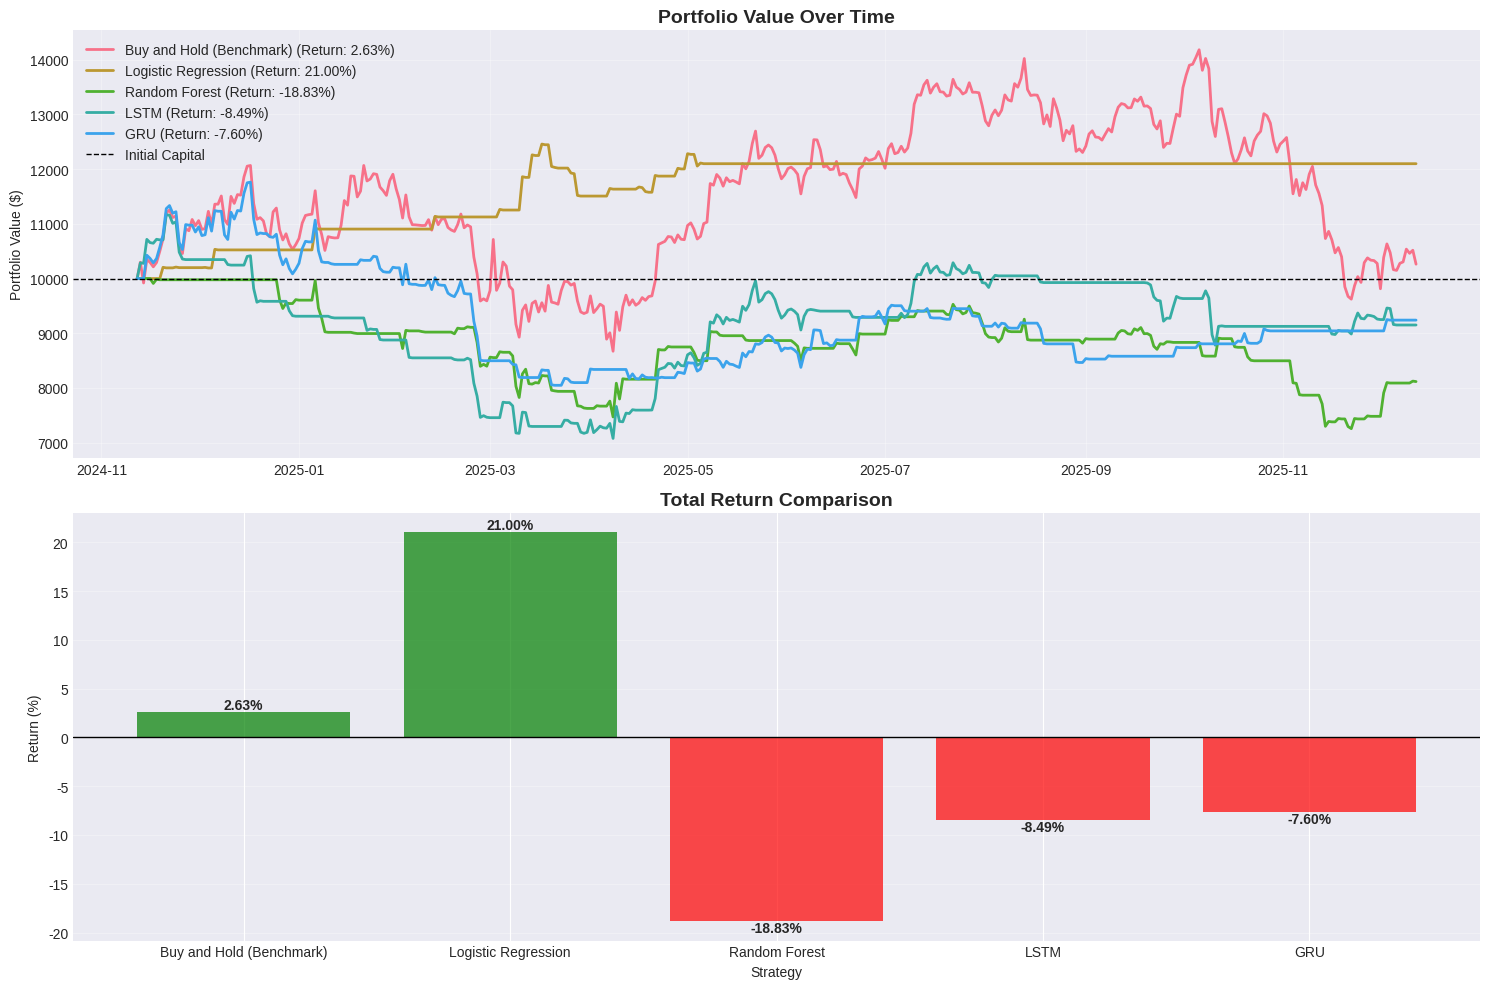

In [45]:
# 시각화
plot_trading_results(all_strategies)

## 8. 결과 분석 및 다음 단계 🚀

### 핵심 인사이트

1. **예측 정확도 ≠ 수익률**
   - 모델의 정확도가 높다고 해서 반드시 수익률이 높은 것은 아님
   - 거래 타이밍, 리스크 관리, 수수료 등이 중요

2. **벤치마크의 중요성**
   - Buy and Hold는 단순하지만 강력한 전략
   - 복잡한 모델이 항상 더 나은 것은 아님

3. **과도한 거래의 위험**
   - 거래가 많을수록 수수료 부담 증가
   - 잘못된 예측의 누적 효과

---

## 📝 과제: 트레이딩 전략 개발

**assignment_notebook.ipynb**에서는:
- 이 벤치마크 모델들의 예측을 활용하거나
- 자신만의 예측 모델을 개발하여
- **Buy and Hold 벤치마크를 초과하는 트레이딩 전략**을 구현하세요!

### 평가 기준
1. **수익률** (60%) - Buy and Hold 대비 초과 수익
2. **전략 설명** (30%) - 논리적이고 창의적인 접근
3. **리스크 관리** (10%) - 안전장치 및 백테스팅

